In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics.cluster import adjusted_rand_score as ARI
from itertools import combinations
import time
from math import sqrt, ceil
from geopy.distance import geodesic
from geopy.point import Point
import networkx as nx

import scipy.sparse.linalg as lg

In [2]:
## the data directory
datadir = '../Datasets/'

## location of the GED code
## use the '-S' option to use split JS divergence
GED = '../GED/GED'

## location of the node2vec code
# n2v = '~/Tools/node2vec/node2vec'
n2v = 'python /Users/hoangnguyen/Downloads/node2vec-master/src/main.py'

In [3]:
## 'N2K' mapping is used to map between node name and key value in graph when reading results from node2vec
def readEmbedding(fn="_embed", N2K=None):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    if N2K!=None:
        x = [N2K[i] for i in D[0]]
        D[0] = x    
        D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    return Y

## Read embedding from file in node2vec format
## Map to layout format
## for visualization, we use UMAP if dim > 2
def embed2layout(fn="_embed"):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    if Y.shape[1]>2:
        Y = umap.UMAP().fit_transform(Y)
    ly = []
    for v in range(Y.shape[0]):
        ly.append((Y[v][0],Y[v][1]))
    return ly


## Computing JS divergence with GED code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, entropy=False):
    if entropy:
        x = GED+' -E -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    else:
        x = GED+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(' ')
    div = float(x[1])
    return(div)


## Hope embedding with various similarity functions
def Hope(g, sim='katz', dim=2, verbose=False, beta=.01, alpha=.5):
    ## For undirected graphs, embedding as source and target are identical
    if g.is_directed() == False:
        dim = dim*2
    A = np.array(g.get_adjacency().data)
    beta = beta
    alpha = alpha
    n = g.vcount()
    ## Katz
    if sim == 'katz':
        M_g = np.eye(n) - beta * A
        M_l = beta * A
    ## Adamic-Adar
    if sim == 'aa':
        M_g = np.eye(n)
        ## fix bug 1/x and take log();
        D = np.diag([1/np.log(x) if x>1 else 0 for x in g.degree()]) 
        # D = np.diag([1/np.log(max(2,x)) for x in g.degree()]) 
        M_l = np.dot(np.dot(A,D),A)
        np.fill_diagonal(M_l,0)
    ## Common neighbors
    if sim == 'cn':
        M_g = np.eye(n)
        M_l = np.dot(A,A)
    ## presonalized page rank
    if sim == 'ppr':
        P = []
        for i in range(n):
            s = np.sum(A[i])
            if s>0:
                P.append([x/s for x in A[i]])
            else:
                P.append([1/n for x in A[i]])
        P = np.transpose(np.array(P)) ## fix bug - take transpose
        M_g = np.eye(n)-alpha*P
        M_l = (1-alpha)*np.eye(n)
    S = np.dot(np.linalg.inv(M_g), M_l)
    u, s, vt = lg.svds(S, k=dim // 2)
    X1 = np.dot(u, np.diag(np.sqrt(s)))
    X2 = np.dot(vt.T, np.diag(np.sqrt(s)))
    X = np.concatenate((X1, X2), axis=1)
    p_d_p_t = np.dot(u, np.dot(np.diag(s), vt))
    eig_err = np.linalg.norm(p_d_p_t - S)
    if verbose:
        print('SVD error (low rank): %f' % eig_err)
    ## undirected graphs have identical source and target embeddings
    if g.is_directed() == False:
        d = dim//2
        return X[:,:d]
    else:
        return X

## save to disk to compute divergence
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(str(g.vs[i]['name'])+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')

## Laplacian eigenmaps embedding
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

# Problem 1

## Generate ABCD graph

In [4]:
abcd_path = '../Datasets/ABCDGraphGenerator.jl-master/utils/'
julia = '/Applications/Julia-1.8.app/Contents/Resources/julia/bin/julia'

In [5]:
node_count = 1000
gamma = 2.5
beta = 1.5
xi = 0.2

os.system(f"rm -r {str(node_count)}")
os.system(f"mkdir {str(node_count)}")

deg_path = f'{node_count}/deg.dat'
cmd = f'{julia} {abcd_path}/deg_sampler.jl {deg_path} {gamma} 10 50 {node_count} 1000'
os.system(cmd)

cs_path = f'{node_count}/cs.dat'
cmd = f'{julia} {abcd_path}/com_sampler.jl {cs_path} {beta} 50 100 {node_count} 1000'
os.system(cmd)

net_path = f'{node_count}/net.dat'
comm_path = f'{node_count}/comm.dat'
cmd = f'{julia} {abcd_path}/graph_sampler.jl {net_path} {comm_path} {deg_path} {cs_path} xi {str(xi)} false false'
os.system(cmd)

[ Info: Usage: julia deg_sampler.jl filename τ₁ d_min d_max n max_iter [seed]
[ Info: Example: julia deg_sampler.jl degrees.dat 3 5 50 10000 1000 42
[ Info: Expected value of degree: 17.59492981753638
[ Info: Usage: julia com_sampler.jl filename τ₂ c_min c_max n max_iter [seed] [nout]
[ Info: Example: julia com_sampler.jl community_sizes.dat 2 50 1000 10000 1000 42 100
[ Info: Expected value of community size: 70.53394879444838
[ Info: Usage: julia graph_sampler.jl networkfile communityfile degreefile communitysizesfile mu|xi fraction isCL islocal [seed] [nout]
[ Info: Example: julia graph_sampler.jl network.dat community.dat degrees.dat community_sizes.dat xi 0.2 true true 42 100


0

## Read ABCD graph

In [9]:
abcd_datadir = '1000/'
abcd_net_file = abcd_datadir+'net.dat'
abcd_comm_file = abcd_datadir+'comm.dat'

In [10]:
## read graph and communities
ABCD = ig.Graph.Read_Ncol(abcd_net_file,directed=False)
c = np.loadtxt(abcd_comm_file,dtype='uint16',usecols=(1))
ABCD.vs['comm'] = [c[int(x['name'])-1] for x in ABCD.vs]

## print a few stats
print(ABCD.vcount(),'vertices,',ABCD.ecount(),'edges,','avg degreee',np.mean(ABCD.degree()),
      'communities',max(ABCD.vs['comm']))

## ground truth communities
GT = {k:(v-1) for k,v in enumerate(ABCD.vs['comm'])}

## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(ABCD.vs['name'])}

## define the colors and node sizes here
## node colors refer to communities
cls_edges = 'gainsboro'
ABCD.vs['size'] = 5
ABCD.es['color'] = cls_edges
pal = ig.RainbowPalette(n=max(ABCD.vs['comm'])+1) 
ABCD.vs['color'] = [pal.get(int(i)) for i in ABCD.vs['comm']]
#ABCD.vs['color'] = 'black'

ig.plot(ABCD, bbox=(0,0,400,300)) ## communities are far from obvious in 2d layout!

1000 vertices, 8701 edges, avg degreee 17.402 communities 14


## Run embedding algorithms

In [12]:
# save ecg community result to file
abcd_ecg_label_ls = ABCD.community_ecg().membership
abcd_ecg_file = abcd_datadir+'abcd.ecg'
with open(abcd_ecg_file, 'w') as fp:
    fp.write("\n".join(str(label) for label in abcd_ecg_label_ls))

In [13]:
def compute_JS_divergence(
    best_jsd, worst_jsd,
    net_file,
    ecg_file,
    _embed_fn='_embed',_embed_best_fn='_embed_best',_embed_worst_fn='_embed_worst'
):
    (best_jsd_, worst_jsd_) = (best_jsd, worst_jsd)
    
    jsd = JS(net_file,ecg_file,_embed_fn)
    ## keep track of best and worst
    if jsd < best_jsd:
        os.system(f'cp {_embed_fn} {_embed_best_fn}')
        best_jsd_ = jsd
    if jsd > worst_jsd:
        os.system(f'cp {_embed_fn} {_embed_worst_fn}')
        worst_jsd_ = jsd
    return (best_jsd_, worst_jsd_, jsd)

def run_hope(
    embedding_count,
    g, best_jsd, worst_jsd, L, DIM, net_file, ecg_file,
    _embed_fn_prefix='',_embed_best_fn='_embed_best',_embed_worst_fn='_embed_worst'
):
    for i in range(embedding_count):
        print('Running Hope...')
        ## Hope with different choices for the similarity
        for dim in DIM:
    #         for sim in ['katz','aa','cn','ppr']:
            for sim in ['ppr']:
                print(f'Running Hope run={i} dim={dim} sim={sim}...')
                X = Hope(g,sim=sim,dim=dim) 
                _embed_fn = f'{_embed_fn_prefix}_Hope_run={i}_dim={dim}_sim={sim}_embed'
                saveEmbedding(X,g,fn=_embed_fn)
                (best_jsd, worst_jsd, jsd) = compute_JS_divergence(
                    best_jsd, worst_jsd, 
                    net_file, ecg_file, _embed_fn, _embed_best_fn, _embed_worst_fn
                )
                L.append([dim,'hope',sim,jsd,i])
    return best_jsd, worst_jsd

def run_le(
    embedding_count,
    g, best_jsd, worst_jsd, L, DIM, net_file, ecg_file,
    _embed_fn_prefix='',_embed_best_fn='_embed_best',_embed_worst_fn='_embed_worst'
):
    for i in range(embedding_count):
        print('Running LE...')
        ## Laplacian Eigenmap
        for dim in DIM:
            print(f'Running LE run={i} dim={dim}...')
            X = LE(g,dim=dim)
            _embed_fn = f'{_embed_fn_prefix}_LE_run={i}_dim={dim}_embed'
            saveEmbedding(X,g,fn=_embed_fn)
            (best_jsd, worst_jsd, jsd) = compute_JS_divergence(
                best_jsd, worst_jsd, 
                net_file, ecg_file, _embed_fn, _embed_best_fn, _embed_worst_fn
            )
            L.append([dim,'le',' ',jsd,i])
    return best_jsd, worst_jsd

def run_node2vec(
    embedding_count,
    g, best_jsd, worst_jsd, L, DIM, net_file, ecg_file,
    _embed_fn_prefix='',_embed_best_fn='_embed_best',_embed_worst_fn='_embed_worst'
):
    for i in range(embedding_count):
        print('Running node2vec...')
        ## node2vec 
        ## we try a few choices for p and q, parameters for the random walks
        ## on some platforms, we got better results with longer random walks (code commented out below)for dim in DIM:
        for dim in DIM:
            # for (p,q) in [(1,0.1),(1,.5),(0.1,1),(.5,1),(1,1)]:
            for (p,q) in [(1,0.1)]:
                print(f'Running node2vec run={i} dim={dim} p={p} q={q}...')
                _embed_fn = f'{_embed_fn_prefix}_node2vec_run={i}_dim={dim}_p={p}_q={q}_embed'
                ## long walks:
                # x = n2v + ' -i:'+net_file+' -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
                ## short walks:
                # x = f'{n2v} -l:15 -i:{net_file} -o:{_embed_fn} -d:{str(dim)} -p:{str(p)} -q:{str(q)}'
                x = f'{n2v} --walk-length 15 --input {net_file} --output {_embed_fn} --dimensions {str(dim)} --p {str(p)} --q {str(q)}'

                print(x)
                r = os.system(x+' >/dev/null')
                print(r)
                (best_jsd, worst_jsd, jsd) = compute_JS_divergence(
                    best_jsd, worst_jsd,
                    net_file, ecg_file, _embed_fn, _embed_best_fn, _embed_worst_fn)
                L.append([dim,'n2v',str(p)+' '+str(q),jsd,i])
    return best_jsd, worst_jsd

In [14]:
def run_exp(g, net_file, ecg_file, prefix, DIM=[4, 8, 16, 32, 64, 128], embedding_count = 30):
    L = []
    # DIM = [2, 4, 5]
    best_jsd = 1           ## keep track of best result
    worst_jsd = 0          ## and worst
    
    _embed_fn_prefix = prefix
    _embed_best_fn = f'{prefix}_embed_best'
    _embed_worst_fn = f'{prefix}_embed_worst'
    
#     (best_jsd, worst_jsd) = run_le(
#         embedding_count,
#         g, best_jsd, worst_jsd, L, DIM, net_file, ecg_file,
#         _embed_fn_prefix, _embed_best_fn, _embed_worst_fn
#     )
    (best_jsd, worst_jsd) = run_hope(
        embedding_count,
        g, best_jsd, worst_jsd, L, DIM, net_file, ecg_file,
        _embed_fn_prefix, _embed_best_fn, _embed_worst_fn
    )
    (best_jsd, worst_jsd) = run_node2vec(
        embedding_count,
        g, best_jsd, worst_jsd, L, DIM, net_file, ecg_file,
        _embed_fn_prefix, _embed_best_fn, _embed_worst_fn
    )
    
    ## store in dataframe and show best results        
    D = pd.DataFrame(L,columns=['dim','algo','param','jsd','run_id'])
    D = D.sort_values(by='jsd',axis=0)
    return D, best_jsd, worst_jsd

In [24]:
(ABCD_D, ABCD_best_jsd, ABCD_worst_jsd) = run_exp(ABCD, abcd_net_file, abcd_ecg_file, "ABCD")
print(ABCD_best_jsd, ABCD_worst_jsd)

Running Hope...
Running Hope run=0 dim=4 sim=ppr...
Running Hope run=0 dim=8 sim=ppr...
Running Hope run=0 dim=16 sim=ppr...
Running Hope run=0 dim=32 sim=ppr...
Running Hope run=0 dim=64 sim=ppr...
Running Hope run=0 dim=128 sim=ppr...
Running Hope...
Running Hope run=1 dim=4 sim=ppr...
Running Hope run=1 dim=8 sim=ppr...
Running Hope run=1 dim=16 sim=ppr...
Running Hope run=1 dim=32 sim=ppr...
Running Hope run=1 dim=64 sim=ppr...
Running Hope run=1 dim=128 sim=ppr...
Running Hope...
Running Hope run=2 dim=4 sim=ppr...
Running Hope run=2 dim=8 sim=ppr...
Running Hope run=2 dim=16 sim=ppr...
Running Hope run=2 dim=32 sim=ppr...
Running Hope run=2 dim=64 sim=ppr...
Running Hope run=2 dim=128 sim=ppr...
Running Hope...
Running Hope run=3 dim=4 sim=ppr...
Running Hope run=3 dim=8 sim=ppr...
Running Hope run=3 dim=16 sim=ppr...
Running Hope run=3 dim=32 sim=ppr...
Running Hope run=3 dim=64 sim=ppr...
Running Hope run=3 dim=128 sim=ppr...
Running Hope...
Running Hope run=4 dim=4 sim=ppr...


0
Running node2vec run=0 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=0_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=1 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=1_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=1 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=1_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=1 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=1_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=1 dim=32 p=1 q=0.1...
python3 /Users

0
Running node2vec run=6 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=6_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=7 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=7_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=7 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=7_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=7 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=7_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=7 dim=32 p=1 q=0.1...
python3 /Users

0
Running node2vec run=12 dim=64 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=12_dim=64_p=1_q=0.1_embed --dimensions 64 --p 1 --q 0.1
0
Running node2vec run=12 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=12_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=13 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=13_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=13 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=13_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=13 dim=16 p=1 q=0.1...
pytho

0
Running node2vec run=18 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=18_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec run=18 dim=64 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=18_dim=64_p=1_q=0.1_embed --dimensions 64 --p 1 --q 0.1
0
Running node2vec run=18 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=18_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=19 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=19_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=19 dim=8 p=1 q=0.1...
pyt

0
Running node2vec run=24 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=24_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=24 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=24_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec run=24 dim=64 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=24_dim=64_p=1_q=0.1_embed --dimensions 64 --p 1 --q 0.1
0
Running node2vec run=24 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input 1000/net.dat --output ABCD_node2vec_run=24_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=25 dim=4 p=1 q=0.1...


In [25]:
display(ABCD_D.head())

dim  algo param       jsd  run_id
179  128  hope   ppr  0.001054      29
53   128  hope   ppr  0.001054       8
23   128  hope   ppr  0.001054       3
155  128  hope   ppr  0.001054      25
149  128  hope   ppr  0.001054      24

In [26]:
ABCD_D_ = ABCD_D.groupby(by=["dim"], as_index=False).agg({"jsd": ["mean", np.std]})
ABCD_D_

dim       jsd          
            mean       std
0    4  0.001370  0.000014
1    8  0.001365  0.000027
2   16  0.001371  0.000010
3   32  0.001350  0.000021
4   64  0.001331  0.000040
5  128  0.001206  0.000154

In [27]:
best_emd = ABCD_D_[('jsd', 'mean')].idxmax()
most_stable = ABCD_D_[('jsd', 'std')].idxmax()

print('Best embedding dim:', ABCD_D_.loc[best_emd]['dim'][0])
print('Most stable dim:', ABCD_D_.loc[most_stable]['dim'][0])

Best embedding dim: 16.0
Most stable dim: 128.0


# Problem 2

In [ ]:
# Reload ABCD graph
abcd_datadir = '1000/'
abcd_net_file = abcd_datadir+'net.dat'
abcd_comm_file = abcd_datadir+'comm.dat'

## read graph and communities
ABCD = ig.Graph.Read_Ncol(abcd_net_file,directed=False)
c = np.loadtxt(abcd_comm_file,dtype='uint16',usecols=(1))
ABCD.vs['comm'] = [c[int(x['name'])-1] for x in ABCD.vs]

## print a few stats
print(ABCD.vcount(),'vertices,',ABCD.ecount(),'edges,','avg degreee',np.mean(ABCD.degree()),
      'communities',max(ABCD.vs['comm']))

## ground truth communities
GT = {k:(v-1) for k,v in enumerate(ABCD.vs['comm'])}

## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(ABCD.vs['name'])}

## define the colors and node sizes here
## node colors refer to communities
cls_edges = 'gainsboro'
ABCD.vs['size'] = 5
ABCD.es['color'] = cls_edges
pal = ig.RainbowPalette(n=max(ABCD.vs['comm'])+1) 
ABCD.vs['color'] = [pal.get(int(i)) for i in ABCD.vs['comm']]
#ABCD.vs['color'] = 'black'

ig.plot(ABCD, bbox=(0,0,400,300)) ## communities are far from obvious in 2d layout!

In [15]:
def run_kmeans_compute_scores(X, g, GT, random_state=0):
    cl = KMeans(n_clusters=len(set(GT.values())), random_state=random_state).fit(X)
    d = {k:v for k,v in enumerate(cl.labels_)}
    ami = AMI(list(GT.values()),list(d.values()))
    ari = ARI(list(GT.values()),list(d.values()))
    agri = ABCD.gam(d,GT)
    
    print("AMI:", ami)
    print("ARI:", ari)
    print("AGRI:", agri)
    return ami, ari, agri

In [16]:
best_nodes_vectors = readEmbedding(fn="abcd_embed_best")
(best_embedding_ami, best_embedding_ari, best_embedding_agri) = run_kmeans_compute_scores(
    best_nodes_vectors, ABCD, GT)

AMI: 0.1687057402453275
ARI: 0.0809958930579529
AGRI: 0.05023912041818268


In [17]:
worst_nodes_vectors = readEmbedding(fn="abcd_embed_worst")
(worst_embedding_ami, worst_embedding_ari, worst_embedding_agri) = run_kmeans_compute_scores(
    worst_nodes_vectors, ABCD, GT)

AMI: 0.13125996426928777
ARI: 0.04723810420402105
AGRI: 0.03167618963894593


# Problem 3

In [31]:
# https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.ring_of_cliques.html
# A ring of cliques is a graph that consists of l complete subgraphs (cliques) of size s
# s = 3 and 3 ≤ l ≤ 48
# l = 10

In [33]:
# Generate a ring of cliques
num_cliques = 20
clique_size = 3
nx_ring_of_cliques = nx.ring_of_cliques(num_cliques, clique_size)
nx_ring_of_cliques

In [34]:
ring_of_cliques = ig.Graph.TupleList(nx_ring_of_cliques.edges(), directed=False)
ring_of_cliques

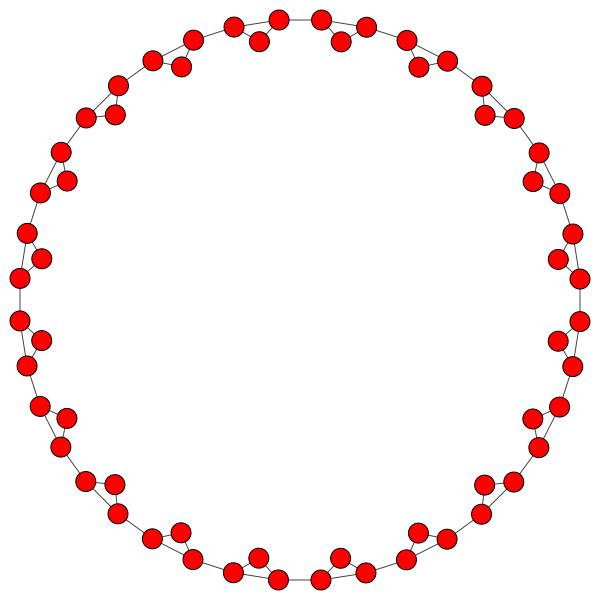

In [35]:
ig.plot(ring_of_cliques)

In [36]:
ring_net_data = [[e.source, e.target] for e in list(ring_of_cliques.es())]
ring_net_file = 'ring_net.dat'
with open(ring_net_file, 'w') as testfile:
    for row in ring_net_data:
        testfile.write(' '.join([str(a) for a in row]) + '\n')

In [37]:
ring_ecg_file = 'ring.ecg'
ring_ecg_label_ls = ring_of_cliques.community_ecg().membership
with open(ring_ecg_file, 'w') as fp:
    fp.write("\n".join(str(label) for label in ring_ecg_label_ls))

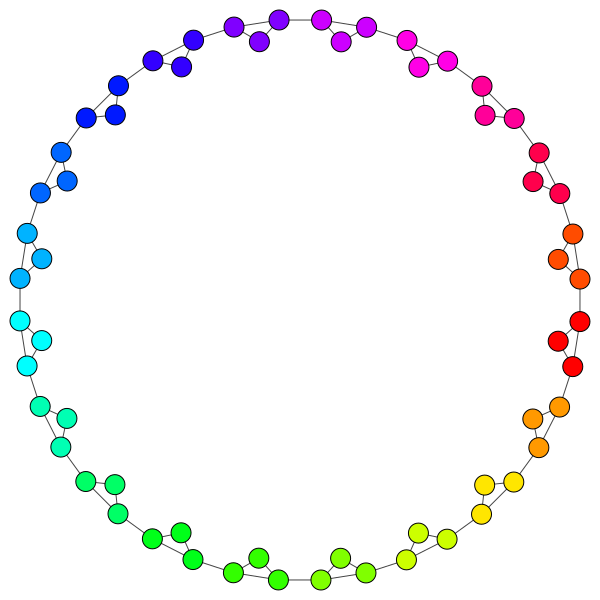

In [38]:
ring_of_cliques.vs['comm'] = [ring_ecg_label_ls[int(x.index)] for x in ring_of_cliques.vs]
pal = ig.RainbowPalette(n=max(ring_of_cliques.vs['comm'])+1) 
ring_of_cliques.vs['color'] = [pal.get(int(i)) for i in ring_of_cliques.vs['comm']]
ig.plot(ring_of_cliques)

In [39]:
(ring_D, ring_best_jsd, ring_worst_jsd) = run_exp(ring_of_cliques, ring_net_file, ring_ecg_file, "ring", [4, 8, 16, 32])
print(ring_best_jsd, ring_worst_jsd)

Running Hope...
Running Hope run=0 dim=4 sim=ppr...
Running Hope run=0 dim=8 sim=ppr...
Running Hope run=0 dim=16 sim=ppr...
Running Hope run=0 dim=32 sim=ppr...
Running Hope...
Running Hope run=1 dim=4 sim=ppr...
Running Hope run=1 dim=8 sim=ppr...
Running Hope run=1 dim=16 sim=ppr...
Running Hope run=1 dim=32 sim=ppr...
Running Hope...
Running Hope run=2 dim=4 sim=ppr...
Running Hope run=2 dim=8 sim=ppr...
Running Hope run=2 dim=16 sim=ppr...
Running Hope run=2 dim=32 sim=ppr...
Running Hope...
Running Hope run=3 dim=4 sim=ppr...
Running Hope run=3 dim=8 sim=ppr...
Running Hope run=3 dim=16 sim=ppr...
Running Hope run=3 dim=32 sim=ppr...
Running Hope...
Running Hope run=4 dim=4 sim=ppr...
Running Hope run=4 dim=8 sim=ppr...
Running Hope run=4 dim=16 sim=ppr...
Running Hope run=4 dim=32 sim=ppr...
Running Hope...
Running Hope run=5 dim=4 sim=ppr...
Running Hope run=5 dim=8 sim=ppr...
Running Hope run=5 dim=16 sim=ppr...
Running Hope run=5 dim=32 sim=ppr...
Running Hope...
Running Hope

0
Running node2vec run=3 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=3_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=3 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=3_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=4 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=4_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=4 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=4_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=4 dim=16 p=1 q=0.1...
python3 /Users/na

0
Running node2vec run=12 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=12_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=12 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=12_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=12 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=12_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=13 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=13_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=13 dim=8 p=1 q=0.1...
python3 /

0
Running node2vec...
Running node2vec run=21 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=21_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=21 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=21_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=21 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=21_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=21 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=21_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=22 dim=4 p=

0
Running node2vec run=29 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input ring_net.dat --output ring_node2vec_run=29_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
0.002057906 0.0411705


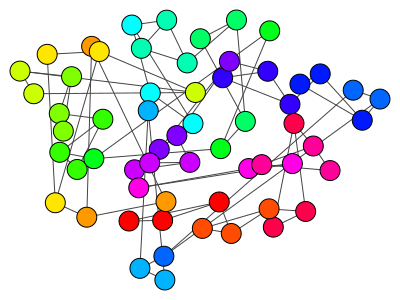

In [40]:
## plot result with lowest JS divergence
os.system('cp ring_embed_best _embed')
l = embed2layout()
ring_of_cliques.vs['ly'] = [l[int(v['name'])-1] for v in ring_of_cliques.vs]
ig.plot(ring_of_cliques, layout=ring_of_cliques.vs['ly'], bbox=(0,0,400,300))

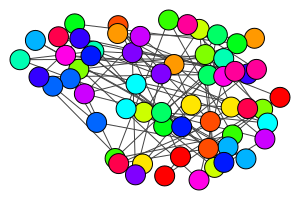

In [41]:
## plot result with high divergence
os.system('cp ring_embed_worst _embed')
l = embed2layout()
ring_of_cliques.vs['ly'] = [l[int(v['name'])-1] for v in ring_of_cliques.vs]
ig.plot(ring_of_cliques, layout=ring_of_cliques.vs['ly'], bbox=(0,0,300,200))

# Problem 4

In [86]:
## read edge list for the grid network and build undirected graph
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some of the attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] ## tuples with lat/lon
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

1562 nodes


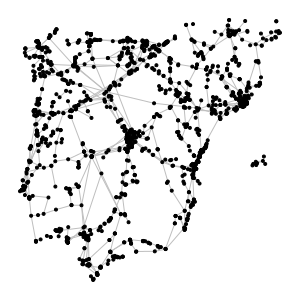

In [87]:
## subgraph of Grid -- Iberic peninsula
V = [v for v in gr.vs() if v['latitude']>36 and v['latitude']<44 and v['longitude']>-10 and v['longitude']<4]
gr_spain = gr.subgraph(V)
ly = ig.Layout(gr_spain.vs['layout'])
ly.mirror(1)
print(gr_spain.vcount(),'nodes')
#ig.plot(gr_spain, 'grid_sg.eps', layout=ly, bbox=(0,0,300,300))
ig.plot(gr_spain, layout=ly, bbox=(0,0,300,300))

In [88]:
gr_spain_giant = gr_spain.connected_components().giant()
gr_spain_giant.vcount()

1537

In [89]:
for v in list(gr_spain_giant.vs()):
    v['name'] = str(v.index)

In [90]:
spain_ecg_file = 'spain.ecg'
spain_ecg_label_ls = gr_spain_giant.community_ecg().membership
with open(spain_ecg_file, 'w') as fp:
    fp.write("\n".join(str(label) for label in spain_ecg_label_ls))

In [91]:
spain_net_data = [[e.source, e.target] for e in list(gr_spain_giant.es())]
spain_net_file = 'spain_net.dat'
with open(spain_net_file, 'w') as testfile:
    for row in spain_net_data:
        testfile.write(' '.join([str(a) for a in row]) + '\n')

In [106]:
(spain_D, spain_best_jsd, spain_worst_jsd) = run_exp(gr_spain_giant, spain_net_file, spain_ecg_file, "spain", embedding_count=30)
print(spain_best_jsd, spain_worst_jsd)
spain_D

Running Hope...
Running Hope run=0 dim=4 sim=ppr...
Running Hope run=0 dim=8 sim=ppr...
Running Hope run=0 dim=16 sim=ppr...
Running Hope run=0 dim=32 sim=ppr...
Running Hope run=0 dim=64 sim=ppr...
Running Hope run=0 dim=128 sim=ppr...
Running Hope...
Running Hope run=1 dim=4 sim=ppr...
Running Hope run=1 dim=8 sim=ppr...
Running Hope run=1 dim=16 sim=ppr...
Running Hope run=1 dim=32 sim=ppr...
Running Hope run=1 dim=64 sim=ppr...
Running Hope run=1 dim=128 sim=ppr...
Running Hope...
Running Hope run=2 dim=4 sim=ppr...
Running Hope run=2 dim=8 sim=ppr...
Running Hope run=2 dim=16 sim=ppr...
Running Hope run=2 dim=32 sim=ppr...
Running Hope run=2 dim=64 sim=ppr...
Running Hope run=2 dim=128 sim=ppr...
Running Hope...
Running Hope run=3 dim=4 sim=ppr...
Running Hope run=3 dim=8 sim=ppr...
Running Hope run=3 dim=16 sim=ppr...
Running Hope run=3 dim=32 sim=ppr...
Running Hope run=3 dim=64 sim=ppr...
Running Hope run=3 dim=128 sim=ppr...
Running Hope...
Running Hope run=4 dim=4 sim=ppr...


0
Running node2vec run=0 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=0_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=1 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=1_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=1 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=1_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=1 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=1_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=1 dim=32 p=1 q=0.1...
python

0
Running node2vec run=6 dim=64 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=6_dim=64_p=1_q=0.1_embed --dimensions 64 --p 1 --q 0.1
0
Running node2vec run=6 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=6_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=7 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=7_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=7 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=7_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=7 dim=16 p=1 q=0.1...
python

0
Running node2vec run=12 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=12_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec run=12 dim=64 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=12_dim=64_p=1_q=0.1_embed --dimensions 64 --p 1 --q 0.1
0
Running node2vec run=12 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=12_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=13 dim=4 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=13_dim=4_p=1_q=0.1_embed --dimensions 4 --p 1 --q 0.1
0
Running node2vec run=13 dim=8 p=1 q=0.

0
Running node2vec run=18 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=18_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=18 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=18_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec run=18 dim=64 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=18_dim=64_p=1_q=0.1_embed --dimensions 64 --p 1 --q 0.1
0
Running node2vec run=18 dim=128 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=18_dim=128_p=1_q=0.1_embed --dimensions 128 --p 1 --q 0.1
0
Running node2vec...
Running node2vec run=19 dim=4 p=1 q

0
Running node2vec run=24 dim=8 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=24_dim=8_p=1_q=0.1_embed --dimensions 8 --p 1 --q 0.1
0
Running node2vec run=24 dim=16 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=24_dim=16_p=1_q=0.1_embed --dimensions 16 --p 1 --q 0.1
0
Running node2vec run=24 dim=32 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=24_dim=32_p=1_q=0.1_embed --dimensions 32 --p 1 --q 0.1
0
Running node2vec run=24 dim=64 p=1 q=0.1...
python3 /Users/navervietnam/Downloads/node2vec-master/src/main.py --walk-length 15 --input spain_net.dat --output spain_node2vec_run=24_dim=64_p=1_q=0.1_embed --dimensions 64 --p 1 --q 0.1
0
Running node2vec run=24 dim=128 p=1 q=0.1...
python3 /Users/n

0
0.06850165 0.1367341


dim  algo  param       jsd  run_id
179  128  hope    ppr  0.068502      29
95   128  hope    ppr  0.068502      15
77   128  hope    ppr  0.068502      12
101  128  hope    ppr  0.068502      16
47   128  hope    ppr  0.068502       7
..   ...   ...    ...       ...     ...
265    8   n2v  1 0.1  0.136734      14
297   32   n2v  1 0.1  0.136734      19
232   64   n2v  1 0.1  0.136734       8
262   64   n2v  1 0.1  0.136734      13
359  128   n2v  1 0.1  0.136734      29

[360 rows x 5 columns]

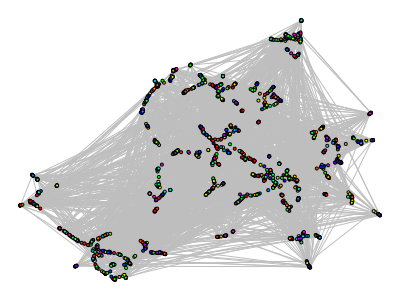

In [107]:
## plot result with lowest JS divergence
os.system('cp spain_embed_best _embed')
l = embed2layout()
gr_spain_giant.vs['ly'] = [l[int(v['name'])-1] for v in gr_spain_giant.vs]
ig.plot(gr_spain_giant, layout=gr_spain_giant.vs['ly'], bbox=(0,0,400,300))

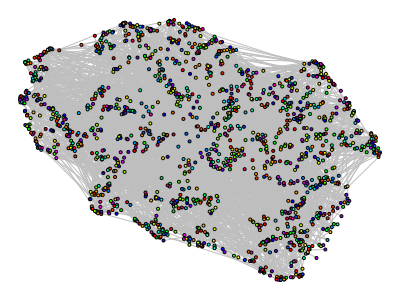

In [108]:
## plot result with lowest JS divergence
os.system('cp spain_embed_worst _embed')
l = embed2layout()
gr_spain_giant.vs['ly'] = [l[int(v['name'])-1] for v in gr_spain_giant.vs]
ig.plot(gr_spain_giant, layout=gr_spain_giant.vs['ly'], bbox=(0,0,400,300))

## a

In [109]:
gr_spain_giant_ecg = gr_spain_giant.community_ecg().membership

In [110]:
pal = ig.RainbowPalette(n=max(gr_spain_giant_ecg)+1)
gr_spain_giant.vs['color'] = [pal.get(int(i)) for i in gr_spain_giant_ecg]

In [111]:
ig.plot(gr_spain_giant, bbox=(0,0,400,300))
plt.show()

## b

In [112]:
def get_embedding_distance(v1, v2, embeddings):
    i1 = int(v1["name"])
    i2 = int(v2["name"])
    e1 = embeddings[i1]
    e2 = embeddings[i2]
    dist = np.linalg.norm(e1-e2)
    return dist

def get_geographical_distance(from_v, to_v):
    from_loc = Point(
        latitude=from_v['latitude'], 
        longitude=from_v['longitude'])
    to_loc = Point(
        latitude=to_v['latitude'], 
        longitude=to_v['longitude'])
    geographical_distance = geodesic(from_loc, to_loc).kilometers
    return geographical_distance

In [113]:
spain_best_nodes_vectors = readEmbedding(fn="spain_embed_best")
spain_best_nodes_vectors

array([[-4.80503732e-03, -1.05667275e-02,  2.26243147e-03, ...,
         6.15870627e-05, -2.02512444e-04, -5.77876895e-03],
       [-9.09014660e-03, -2.00519253e-02,  4.29600148e-03, ...,
         1.32402045e-04, -4.36785787e-04, -1.25832156e-02],
       [-3.32022986e-03, -5.40395270e-04, -2.05061457e-05, ...,
         8.73522673e-03, -6.09304213e-03, -1.90261239e-06],
       ...,
       [ 2.53723898e-02, -7.83159447e-04, -4.55231251e-04, ...,
         4.16046597e-03, -2.30084554e-02, -1.05006023e-04],
       [-7.96424212e-04, -2.31709265e-03,  6.93081087e-04, ...,
         2.61729924e-04, -6.31397461e-04, -4.02620619e-02],
       [-1.00521944e-02,  3.49843782e-04,  9.59512637e-05, ...,
         3.10682213e-03, -2.35344928e-02, -7.81853855e-05]])

In [114]:
comb = list(combinations(list(gr_spain_giant.vs()), 2))
len(comb)

1180416

In [115]:
dist_dict = {}
geo_ls = []
embedding_ls = []
for i, (v1, v2) in enumerate(comb):
    if i%100000 == 0:
        print(i)
    geo_dist = get_geographical_distance(v1, v2)
    geo_ls.append(geo_dist)
    embedding_dist = get_embedding_distance(v1, v2, spain_best_nodes_vectors)
    embedding_ls.append(embedding_dist)
    dist_dict[(v1["name"], v2["name"])] = embedding_dist

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


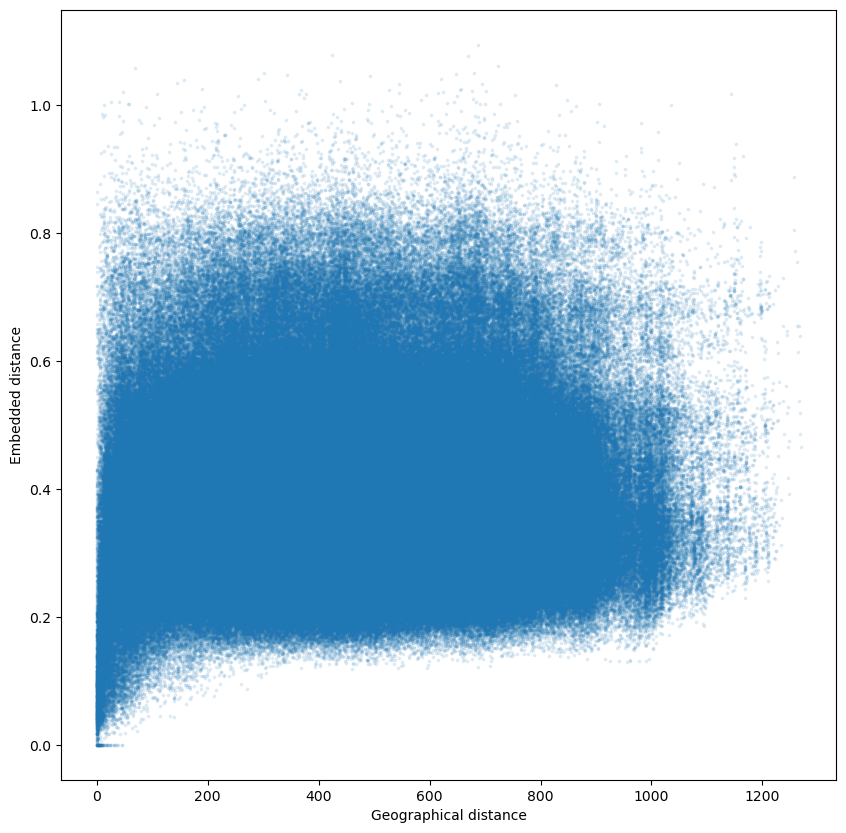

In [116]:
plt.figure(figsize=(10,10))
geos = np.array(geo_ls)
embs = np.array(embedding_ls)

plt.scatter(geos, embs, s=3, alpha=0.1)
plt.xlabel('Geographical distance')
plt.ylabel('Embedded distance')
plt.show()

## c

In [117]:
BUCKET_COUNT = 10
dist_dict_sorted = {k: v for k, v in sorted(dist_dict.items(), key=lambda item: item[1])}
buckets = np.array_split(np.array(list(dist_dict_sorted.keys())), BUCKET_COUNT)

In [118]:
bucket_dict = {}
for i, bucket in enumerate(buckets):
    count = 0
    for pair in bucket:
        if gr_spain_giant.are_connected(pair[0], pair[1]):
            count += 1
    bucket_dict[i] = count

In [119]:
bucket_dict

{0: 1640, 1: 99, 2: 66, 3: 49, 4: 43, 5: 30, 6: 17, 7: 9, 8: 7, 9: 2}

In [ ]:
# Bucket containing closer pairs has more edges in the graph